# Authors
- Tomás Fonseca

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.stats import linregress
import scipy
import statistics as stat
from tqdm import tqdm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import QuantLib as ql

## DataSet Walmart

In [2]:
dataset = pd.read_excel('dataset_walmart.xlsx', index_col = 0)
dataset = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')] # To clean "Unnamed" columns
dataset.head(5)

,Close share price (USD),Book value/share (USD),Nº Shares (Million),ST Debt (Million),LT Debt (Million),30-day Implied Vol,Risk-free rate (%),SP 500 close spot
Date,,,,,,,,
2011-02-01,56.330002,20.26,3670,58603,43842,0.1453,3.443,1307.59
2011-02-02,55.860001,20.26,3670,58603,43842,0.1453,3.489,1304.03
2011-02-03,55.919998,20.26,3670,58603,43842,0.1453,3.541,1307.10
2011-02-04,56.029999,20.26,3670,58603,43842,0.1453,3.652,1310.87
2011-02-07,56.070000,20.26,3670,58603,43842,0.1453,3.644,1319.05


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2011-02-01 to 2021-02-26
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Close share price (USD)  2535 non-null   float64
 1   Book value/share (USD)   2535 non-null   float64
 2   Nº Shares (Million)      2535 non-null   int64  
 3   ST Debt (Million)        2535 non-null   int64  
 4   LT Debt (Million)        2535 non-null   int64  
 5   30-day Implied Vol       2535 non-null   float64
 6   Risk-free rate (%)       2535 non-null   float64
 7   SP 500 close spot        2535 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 178.2 KB


# Exercise 2
## a) Firm Analysis

In [4]:
dataset['Market Cap (Million)'] = (dataset['Close share price (USD)']*dataset['Nº Shares (Million)']).round(0)
dataset['Company Value'] = (dataset['Market Cap (Million)'] + dataset['ST Debt (Million)'] + dataset['LT Debt (Million)']).round(0)
dataset['Equity book value'] = (dataset['Book value/share (USD)']*dataset['Nº Shares (Million)']).round(0)
dataset['Price to book'] = (dataset['Close share price (USD)']/dataset['Book value/share (USD)']).round(2)
dataset['Debt/Equity (%)'] = ((dataset['ST Debt (Million)'] + dataset['LT Debt (Million)'])/dataset['Market Cap (Million)']).round(4)*100
dataset['Debt/Value (%)'] = ((dataset['ST Debt (Million)'] + dataset['LT Debt (Million)'])/(dataset['Market Cap (Million)'] + \
                    dataset['ST Debt (Million)'] + dataset['LT Debt (Million)'])).round(4)*100

dataset['Daily Return on Equity (%)'] = (np.log(dataset['Close share price (USD)']/dataset['Close share price (USD)'].shift(1))).round(4)*100
dataset.drop(columns='Risk-free rate (%)')

,Close share price (USD),Book value/share (USD),Nº Shares (Million),ST Debt (Million),LT Debt (Million),30-day Implied Vol,SP 500 close spot,Market Cap (Million),Company Value,Equity book value,Price to book,Debt/Equity (%),Debt/Value (%),Daily Return on Equity (%)
Date,,,,,,,,,,,,,,
2011-02-01,56.330002,20.26,3670,58603,43842,0.1453,1307.59,206731.0,309176.0,74354.0,2.78,49.55,33.13,NaN
2011-02-02,55.860001,20.26,3670,58603,43842,0.1453,1304.03,205006.0,307451.0,74354.0,2.76,49.97,33.32,-0.84
2011-02-03,55.919998,20.26,3670,58603,43842,0.1453,1307.10,205226.0,307671.0,74354.0,2.76,49.92,33.30,0.11
2011-02-04,56.029999,20.26,3670,58603,43842,0.1453,1310.87,205630.0,308075.0,74354.0,2.77,49.82,33.25,0.20
2011-02-07,56.070000,20.26,3670,58603,43842,0.1453,1319.05,205777.0,308222.0,74354.0,2.77,49.78,33.24,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,137.690002,28.73,2826,88121,40849,0.2357,3876.50,389112.0,518082.0,81191.0,4.79,33.14,24.89,-0.47
2021-02-23,135.470001,28.73,2826,88121,40849,0.2357,3881.37,382838.0,511808.0,81191.0,4.72,33.69,25.20,-1.63
2021-02-24,133.210007,28.73,2826,88121,40849,0.2357,3925.43,376451.0,505421.0,81191.0,4.64,34.26,25.52,-1.68


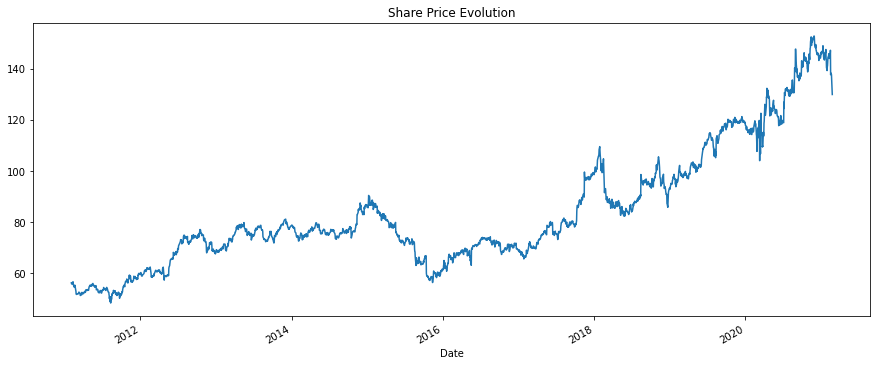

In [5]:
dataset['Close share price (USD)'].plot(figsize=(15,6), title ='Share Price Evolution');

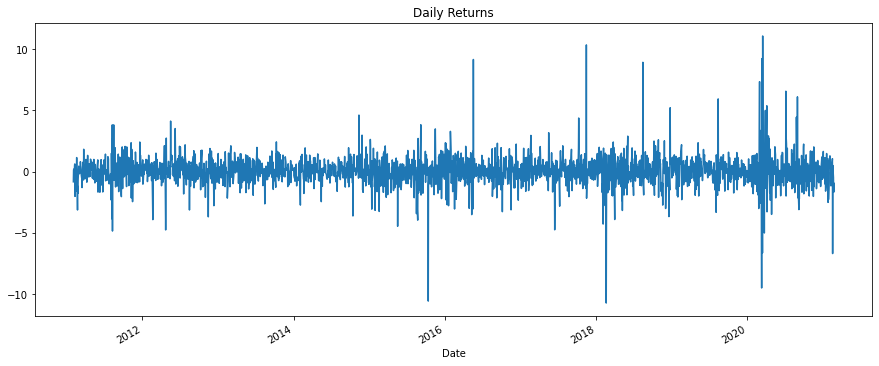

In [6]:
dataset['Daily Return on Equity (%)'].plot(figsize=(15,6), title ='Daily Returns');

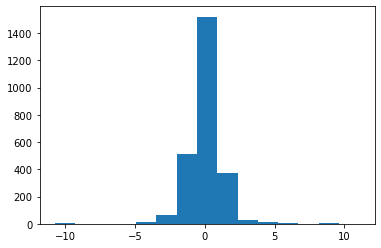

In [7]:
plt.hist(dataset['Daily Return on Equity (%)'], bins = 15);

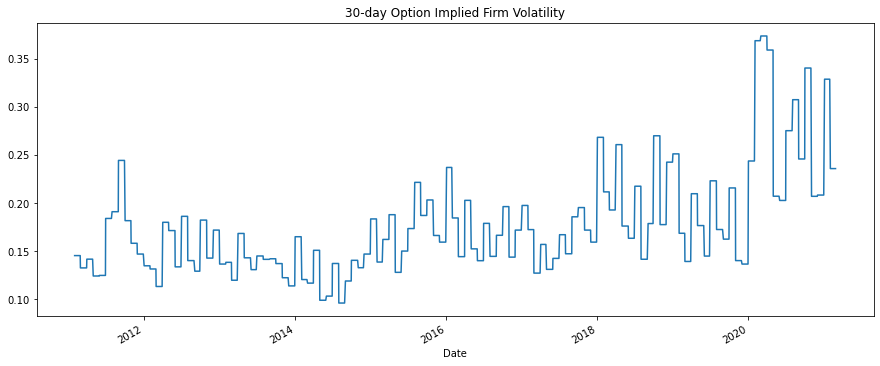

In [8]:
dataset['30-day Implied Vol'].plot(figsize=(15,6), title ='30-day Option Implied Firm Volatility');

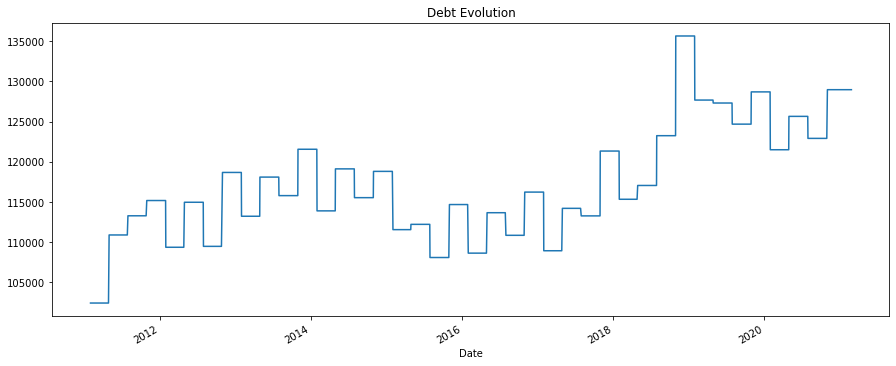

In [9]:
debt_evolution = dataset['ST Debt (Million)'] + dataset['LT Debt (Million)']
debt_evolution.plot(figsize=(15,6), title ='Debt Evolution');

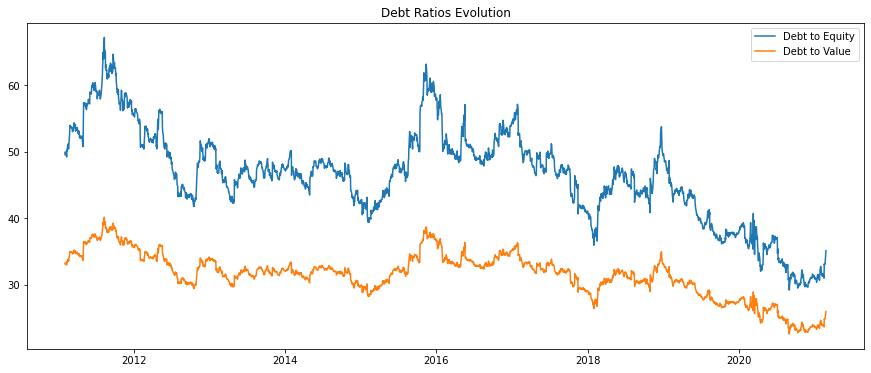

In [10]:
plt.figure(figsize=(15, 6))
plt.title('Debt Ratios Evolution')
plt.plot(dataset['Debt/Equity (%)'], label='Debt to Equity')
plt.plot(dataset['Debt/Value (%)'], label='Debt to Value')
plt.legend();

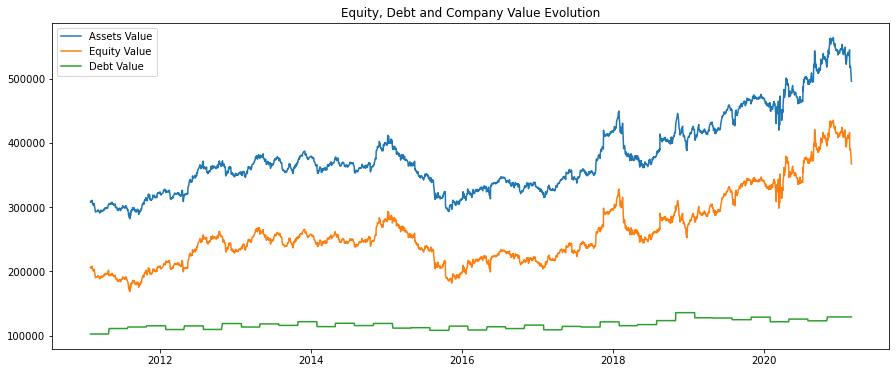

In [11]:
plt.figure(figsize=(15, 6))
plt.title('Equity, Debt and Company Value Evolution')
plt.plot(dataset['Company Value'], label='Assets Value')
plt.plot(dataset['Market Cap (Million)'], label='Equity Value')
plt.plot(debt_evolution, label='Debt Value')
plt.legend()

In [12]:
df = dataset
df.drop(columns =['Close share price (USD)', 'Book value/share (USD)','Nº Shares (Million)',\
                      'Risk-free rate (%)','SP 500 close spot']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ST Debt (Million),2535.0,72861.710454,7035.295888,58603.000,67942.0000,71818.0000,78521.0000,88121.0000
LT Debt (Million),2535.0,44289.821696,3528.927534,36305.000,41836.0000,43842.0000,47079.0000,51568.0000
30-day Implied Vol,2535.0,0.176460,0.054706,0.096,0.1401,0.1662,0.1962,0.3735
Market Cap (Million),2535.0,260494.368836,55269.576462,168709.000,222292.0000,248419.0000,283313.0000,435299.0000
Company Value,2535.0,377645.900986,60566.051843,282001.000,334270.0000,364135.0000,410319.5000,564269.0000
Equity book value,2535.0,79250.469034,4022.885091,68644.000,76546.0000,79664.0000,82414.0000,88063.0000
Price to book,2535.0,3.284521,0.658508,2.190,2.8200,3.1300,3.5600,5.1500
Debt/Equity (%),2535.0,46.391065,7.074871,29.220,42.8800,46.9000,50.4050,67.1500
Debt/Value (%),2535.0,31.528012,3.356602,22.620,30.0100,31.9200,33.5100,40.1700
Daily Return on Equity (%),2534.0,0.032968,1.230023,-10.740,-0.5200,0.0400,0.6100,11.0700


### Risk-free Rate Analysis 

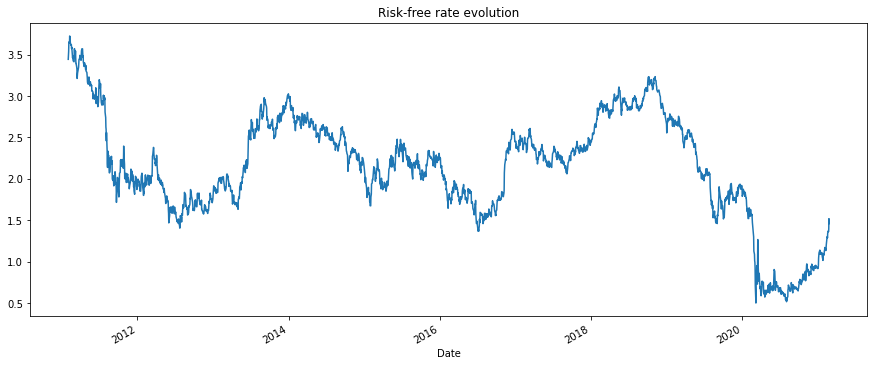

In [13]:
dataset['Risk-free rate (%)'].plot(figsize=(15,6), title ='Risk-free rate evolution');

In [14]:
average_annual_return_on_equity = dataset['Daily Return on Equity (%)'].mean()*252
print('The average annual return on equity is',round(average_annual_return_on_equity,2),'%')

The average annual return on equity is 8.31 %


In [15]:
dataset['Risk-free rate (%)'].describe()

count    2535.000000
mean        2.139153
std         0.639445
min         0.499000
25%         1.774000
50%         2.182000
75%         2.592000
max         3.725000
Name: Risk-free rate (%), dtype: float64

## b) Compute the Dist. to Def. and Prob. Def. with non-linear system of equations approach for 1 year of historical data

### Functions 

In [46]:

# Bharath and Shumway Equation 10
def sigmaNaiveFunction(equity, face_value, sigmaE):
    return (equity / (equity + face_value)) * sigmaE + (face_value / (equity + face_value)) * (0.05 + 0.25 * sigmaE)

# Compute Asset volatility
def sigmaValues(prices):
    assVol = np.nanstd(prices)*(len(prices)**0.5)
    return assVol

def assetVolatilityFunction(iter_K):
    testLogReturns = []
    for i in np.arange(1,len(iter_K)):
        testLogReturns.append(np.log(iter_K[i] / iter_K[i-1]))
    assVol = np.nanstd(testLogReturns)*(len(iter_K)**0.5)
    return assVol
    
# Compute non system of linear eqautions with solver 
def primarySystemEquation(equity_E, debt_X, r, tau, sigmaEquity):
#     print("Simga E:", sigmaEquity,"\nRate:",lastRateVal,"\nEquity:",lastEquityValue,"\nLiabilities:",lastLiabilitiesValue)

    # Starting Points for System of equations
    V = debt_X + equity_E
    v = sigmaEquity * (equity_E/V)
#     print("V = {} \nv = {}".format(V,v))
        
    def nonlinearsystem(z):
        V = z[0] # Market value of assets
        v = z[1] # Implied volatility
        f = np.zeros(2)
        d1 = (np.log(V/debt_X) + (r+0.5 * v**2)*tau) / (v*(tau**0.5))
        d2 = d1 - v*(tau**0.5)
        NormalDistD1 = norm.cdf(d1)
        NormalDistD2 = norm.cdf(d2)
        EFit = V * NormalDistD1 - (debt_X*np.exp(-r*tau)) * NormalDistD2
        eFit = v * NormalDistD1 * V/equity_E
        f[0] = (EFit - equity_E)/equity_E
        f[1] = (eFit - sigmaEquity)/sigmaEquity
        return f

    z = fsolve(nonlinearsystem,[V,v])
    return z


# Solver for question b
# def solverQuestB(z):
#     sigma_value_b,d1_b = z
    
#     equity_b = dataset.loc['2021-02-26', 'Market Cap (Million)']
#     sigma_equity_b = sigmaValues(((dataset['Daily Return on Equity (%)'].iloc[(dataset.index >='2020-02-26')])*0.01).array)
#     debt_b = dataset.loc['2021-02-26', 'ST Debt (Million)'] + dataset.loc['2021-02-26', 'LT Debt (Million)'] * 0.5
#     r_b = dataset.loc['2021-02-26', 'Risk-free rate (%)'] * 0.01
#     tau_b = 1
    
#     value_b = equity_b + debt_b
    
#     f1 = (np.log(value_b/debt_b) + (r_b + 0.5*sigma_value_b**2) * tau_b) / (sigma_value_b * np.sqrt(tau_b)) - d1_b
#     f2 = ((value_b/equity_b) * norm.cdf(d1_b) * sigma_value_b) - sigma_equity_b
#     return [f1,f2]


# Computer Distance to Default and Probability of Default
# Also used for Naive Bharath and Shumway Equation 12
def DD_PD(V_t,sigma_V,lastLiabilitiesValue,t,drift_R):
    results = []
    d1 = (np.log(V_t/lastLiabilitiesValue) + (drift_R+0.5 * sigma_V**2) *t) / (sigma_V*t**0.5)
    d2 = d1 - sigma_V*t**0.5
    probDef = norm.cdf(-d2)
    results.extend([d1,d2,probDef])
    return results




In [18]:
# Get the number of months to iterate
uniqueMonthYear = dataset.index.strftime("%Y-%m").unique().tolist()
print('In our data we have to iterate over {} months'.format(len(uniqueMonthYear)))

In our data we have to iterate over 121 months


In [23]:
# Compute the last working day of each month
d1 = ql.Date('2011-02-01','%Y-%m-%d')
d2 = ql.Date('2021-02-26','%Y-%m-%d')
date = ql.UnitedStates(ql.UnitedStates().NYSE).businessDayList(d1,d2)
dateEndMonth = []
for i in date:
    dateEndMonth.append((ql.UnitedStates(ql.UnitedStates().NYSE).endOfMonth(i)).ISO())
dateEndMonth = list(dict.fromkeys(dateEndMonth))
dateEndMonth

['2011-02-28',
 '2011-03-31',
 '2011-04-29',
 '2011-05-31',
 '2011-06-30',
 '2011-07-29',
 '2011-08-31',
 '2011-09-30',
 '2011-10-31',
 '2011-11-30',
 '2011-12-30',
 '2012-01-31',
 '2012-02-29',
 '2012-03-30',
 '2012-04-30',
 '2012-05-31',
 '2012-06-29',
 '2012-07-31',
 '2012-08-31',
 '2012-09-28',
 '2012-10-31',
 '2012-11-30',
 '2012-12-31',
 '2013-01-31',
 '2013-02-28',
 '2013-03-28',
 '2013-04-30',
 '2013-05-31',
 '2013-06-28',
 '2013-07-31',
 '2013-08-30',
 '2013-09-30',
 '2013-10-31',
 '2013-11-29',
 '2013-12-31',
 '2014-01-31',
 '2014-02-28',
 '2014-03-31',
 '2014-04-30',
 '2014-05-30',
 '2014-06-30',
 '2014-07-31',
 '2014-08-29',
 '2014-09-30',
 '2014-10-31',
 '2014-11-28',
 '2014-12-31',
 '2015-01-30',
 '2015-02-27',
 '2015-03-31',
 '2015-04-30',
 '2015-05-29',
 '2015-06-30',
 '2015-07-31',
 '2015-08-31',
 '2015-09-30',
 '2015-10-30',
 '2015-11-30',
 '2015-12-31',
 '2016-01-29',
 '2016-02-29',
 '2016-03-31',
 '2016-04-29',
 '2016-05-31',
 '2016-06-30',
 '2016-07-29',
 '2016-08-

In [25]:
# Main function for question 2. B)
df_B = pd.DataFrame(columns=['End of Month','Distance to Default','Probability of Default'])

for idx in np.arange(0,len(dateEndMonth)):
    adjustedDate = ql.Date(dateEndMonth[idx],'%Y-%m-%d') - ql.Period('1Y')
    adjustedDate = adjustedDate.ISO()
    print("Date: ",dateEndMonth[idx],"\tPrevious Year Date: ",adjustedDate)

    equity_E = dataset['Market Cap (Million)'].loc[dateEndMonth[idx]] 
    debt_X = dataset['ST Debt (Million)'].loc[dateEndMonth[idx]] + (dataset['LT Debt (Million)'].loc[dateEndMonth[idx]] * 0.5)
    r = dataset.loc[dateEndMonth[idx], 'Risk-free rate (%)'] * 0.01
    tau = 1
    sigmaEquity = sigmaValues(((dataset['Daily Return on Equity (%)'].loc[((dataset.index >= adjustedDate) & (dataset.index <= dateEndMonth[idx]))])*0.01).array)   
    print('\nEquity:',equity_E,'\tBook Liabilities:',debt_X,'\tInt. Rate:',r,'\tTau:',tau,'\tSigma of Equity:',sigmaEquity)

    x_b = primarySystemEquation(equity_E, debt_X, r, tau, sigmaEquity)    
    print('The company value E fitted: ', x_b[0].round(4), '\tSigma E fitted: ', x_b[1].round(4))
    
    # Compute Distance to Default and Probability of Default
    DD_PD_Result = DD_PD(x_b[0],x_b[1],debt_X,tau,r)
    
    # Append DD and PD computed at the end of each month in the DataFrame created for question 2.B)
    new_row = {'End of Month':dateEndMonth[idx], 'Distance to Default':DD_PD_Result[1], 'Probability of Default':DD_PD_Result[2]}
    df_B = df_B.append(new_row, ignore_index=True)

    print('d1: ', DD_PD_Result[0],'\tDD: ',DD_PD_Result[1],'\tProb. Default: ',DD_PD_Result[2])
    print("===============================================================================================================================")
    print("===============================================================================================================================")

Date:  2011-02-28 	Previous Year Date:  2010-02-28

Equity: 190767.0 	Book Liabilities: 80524.0 	Int. Rate: 0.034140000000000004 	Tau: 1 	Sigma of Equity: 0.047932255435261036
The company value E fitted:  268588.3081 	Sigma E fitted:  0.034
d1:  36.40389484539158 	DD:  36.36985057653445 	Prob. Default:  6.380383700527487e-290
Date:  2011-03-31 	Previous Year Date:  2010-03-31

Equity: 191023.0 	Book Liabilities: 80524.0 	Int. Rate: 0.03454 	Tau: 1 	Sigma of Equity: 0.05743061240251595
The company value E fitted:  268813.1858 	Sigma E fitted:  0.0408
d1:  30.404313357211088 	DD:  30.363502234644645 	Prob. Default:  8.334289955111116e-203
Date:  2011-04-29 	Previous Year Date:  2010-04-29

Equity: 201777.0 	Book Liabilities: 80524.0 	Int. Rate: 0.032959999999999996 	Tau: 1 	Sigma of Equity: 0.06454560974771961
The company value E fitted:  279690.1914 	Sigma E fitted:  0.0466
d1:  27.470566308562198 	DD:  27.42400114504638 	Prob. Default:  7.0959461483903e-166
Date:  2011-05-31 	Previous 

In [27]:
# All Distance to Default and Probability of Default for the end of each month
df_B

,End of Month,Distance to Default,Probability of Default
0,2011-02-28,36.369851,6.380384e-290
1,2011-03-31,30.363502,8.334290e-203
2,2011-04-29,27.424001,7.095946e-166
3,2011-05-31,24.632350,2.844645e-134
4,2011-06-30,21.286187,7.621835e-101
...,...,...,...
116,2020-10-30,6.347695,1.092824e-10
117,2020-11-30,6.360780,1.003661e-10
118,2020-12-31,6.232555,2.294443e-10
119,2021-01-29,6.138148,4.174452e-10


## C) Compute Distance to Default e Prob. of Default, non linear system of equation approach for every month
- The Equity Volatility is refered as the column "30-day Implied Vol"

In [327]:
dataset.head(1)

,Close share price (USD),Book value/share (USD),Nº Shares (Million),ST Debt (Million),LT Debt (Million),30-day Implied Vol,Risk-free rate (%),Market Cap (Million),Equity book value,Price to book,Debt/Equity (%),Debt/Value (%),Daily Return on Equity (%)
Date,,,,,,,,,,,,,
2011-02-01,56.330002,20.26,3670,58603,43842,0.1453,3.443,206731.0,74354.0,2.78,49.55,33.13,NaN


In [28]:
# Main function question 2. B)
df_C = pd.DataFrame(columns=['End of Month','Distance to Default','Probability of Default'])

for idx in np.arange(0,len(dateEndMonth)):
    adjustedDate = ql.Date(dateEndMonth[idx],'%Y-%m-%d') - ql.Period('1Y')
    adjustedDate = adjustedDate.ISO()
    print("Date: ",dateEndMonth[idx],"\tPrevious Year Date: ",adjustedDate)

    equity_E = dataset['Market Cap (Million)'].loc[dateEndMonth[idx]] 
    debt_X = dataset['ST Debt (Million)'].loc[dateEndMonth[idx]] + (dataset['LT Debt (Million)'].loc[dateEndMonth[idx]] * 0.5)
    r = dataset.loc[dateEndMonth[idx], 'Risk-free rate (%)'] * 0.01
    tau = 1
    sigmaEquity = dataset['30-day Implied Vol'].loc[dateEndMonth[idx]]
    print('\nEquity:',equity_E,'\tBook Liabilities:',debt_X,'\tInt. Rate:',r,'\tTau:',tau,'\tEquity Volatility:',sigmaEquity)

    x_b = primarySystemEquation(equity_E, debt_X, r, tau, sigmaEquity)    
    print('The company value E fitted: ', x_b[0].round(4), '\tSigma E fitted: ', x_b[1].round(4))
    
    DD_PD_Result = DD_PD(x_b[0],x_b[1],debt_X,tau,r)  
    
    # Append DD and PD computed at the end of each month in the DataFrame created for question 2.B)
    new_row = {'End of Month':dateEndMonth[idx], 'Distance to Default':DD_PD_Result[1], 'Probability of Default':DD_PD_Result[2]}
    df_C = df_C.append(new_row, ignore_index=True)
                       
    print('d1: ', DD_PD_Result[0],'\tDD: ',DD_PD_Result[1],'\tProb. Default: ',DD_PD_Result[2])                   
    print("===============================================================================================================================")
    print("===============================================================================================================================")

Date:  2011-02-28 	Previous Year Date:  2010-02-28

Equity: 190767.0 	Book Liabilities: 80524.0 	Int. Rate: 0.034140000000000004 	Tau: 1 	Equity Volatility: 0.1453
The company value E fitted:  268588.3081 	Sigma E fitted:  0.1032
d1:  12.055074968319355 	DD:  11.951874477960187 	Prob. Default:  3.173857241783759e-33
Date:  2011-03-31 	Previous Year Date:  2010-03-31

Equity: 191023.0 	Book Liabilities: 80524.0 	Int. Rate: 0.03454 	Tau: 1 	Equity Volatility: 0.1325
The company value E fitted:  268813.1858 	Sigma E fitted:  0.0942
d1:  13.216636298733107 	DD:  13.12247965450034 	Prob. Default:  1.2239605572898081e-39
Date:  2011-04-29 	Previous Year Date:  2010-04-29

Equity: 201777.0 	Book Liabilities: 80524.0 	Int. Rate: 0.032959999999999996 	Tau: 1 	Equity Volatility: 0.1416
The company value E fitted:  279690.1914 	Sigma E fitted:  0.1022
d1:  12.562388457529238 	DD:  12.460233916273662 	Prob. Default:  6.150464144923691e-36
Date:  2011-05-31 	Previous Year Date:  2010-05-31

Equity:

In [29]:
# All Distance to Default and Probability of Default for the end of each month
df_C

,End of Month,Distance to Default,Probability of Default
0,2011-02-28,11.951874,3.173857e-33
1,2011-03-31,13.122480,1.223961e-39
2,2011-04-29,12.460234,6.150464e-36
3,2011-05-31,13.777902,1.730931e-43
4,2011-06-30,13.568693,3.070370e-42
...,...,...,...
116,2020-10-30,5.729911,5.024163e-09
117,2020-11-30,9.672444,1.974172e-22
118,2020-12-31,9.447970,1.727319e-21
119,2021-01-29,5.866221,2.229196e-09


## D) Compute Distance to Default e Prob. of Default, using the iterative approach


#### Loop iteration

In [33]:
def itertive_function(equityValue, liabilitiesValue, intrate, assetValue):
    #Parameters
    errortol = 0.0000
    maxitr = 10000
    k = 0;

    old_sigma = assetVolatilityFunction(assetValue)
    assetvalue_newvector = []
    flat_assetvalue_newvector = []
    results = []

    while 1:
        k += 1
        flag = 0    

        for i in np.arange(0,len(equityValue)):
            teste3 = (np.log(assetValue[i]/liabilitiesValue[i]) + (intrate[i] + 0.5*(old_sigma**2))*1) / (old_sigma*(1**0.5))
            round(teste3,0)
            assetvalue_newvector.append(np.round((equityValue[i] + liabilitiesValue[i]*np.exp(-intrate[i])*norm.cdf(teste3-old_sigma*(1**0.5)))/(norm.cdf(teste3)), decimals=0))

        flat_assetvalue_newvector = np.round(assetvalue_newvector,decimals=0)
        assetvalue_newvector = []

        # Asset volatility
        new_sigma = assetVolatilityFunction(flat_assetvalue_newvector)

        # Sum of Squared errors (SSE)
        sqdiff = (np.array(flat_assetvalue_newvector) - np.array(assetValue))**2
        error2 = sum(sqdiff)

        if (error2<=errortol) or (k>maxitr):
            y = new_sigma
            break

        assetValue = flat_assetvalue_newvector
        flat_assetvalue_newvector = []
        old_sigma = new_sigma
        
    return assetValue, y

#### Main

In [35]:
# Create a DataFrame to store all results
df_D = pd.DataFrame(columns=['End of Month','Distance to Default','Probability of Default','Drift Miu'])
df_D_extra = pd.DataFrame(columns=['Asset Value(iter k)','S&P 500','risk-free'])
df_E = pd.DataFrame(columns=['End of Month','Market Value of the firm','sigma_V','Liabilities(X)','Drift Miu'])

for idx in np.arange(0,len(dateEndMonth)):
    adjustedDate = ql.Date(dateEndMonth[idx],'%Y-%m-%d') - ql.Period('1Y')
    adjustedDate = adjustedDate.ISO()
    print("Date: ",dateEndMonth[idx],"\tPrevious Year Date: ",adjustedDate)
     
    tau = 1    
    equity_iter = np.array(dataset['Market Cap (Million)'].loc[(dataset.index >= adjustedDate) & (dataset.index <= dateEndMonth[idx])]) 
    debt_iter = np.array(dataset['ST Debt (Million)'].loc[(dataset.index >= adjustedDate) & (dataset.index <= dateEndMonth[idx])] + \
                        (dataset['LT Debt (Million)'].loc[(dataset.index >= adjustedDate) & (dataset.index <= dateEndMonth[idx])] * 0.5)) 
    r_iter = np.array(dataset.loc[((dataset.index >= adjustedDate) & (dataset.index <= dateEndMonth[idx])), 'Risk-free rate (%)'] * 0.01)
    assetValue = equity_iter + debt_iter # iter k# iter k
    sigmaEquity_iter = sigmaValues(((dataset['Daily Return on Equity (%)'].loc[(dataset.index >= adjustedDate) & (dataset.index <= dateEndMonth[idx])])*0.01).array)   
        
    iterResults = itertive_function(equity_iter, debt_iter, r_iter, assetValue)
    print('\nEquity:',equity_iter,'\nBook Liabilities:',debt_iter,'\nAsset Value:',assetValue,'\nInt. Rate:',r_iter,'\nTau:',tau,'\nSigma of Equity:',sigmaEquity_iter)
    print('\nResults', iterResults)
    
    # DD and PD computation
    V_t = iterResults[0][-1]
    sigma_V = iterResults[1] 
    X = debt_iter[-1]
    tau = 1
    drift_R = r_iter[-1]
    print("\nMarket Value of the firm: ",V_t,"\nsigma_V: ",sigma_V,"\nLiabilities(X): ",X,"\nT: ",tau,"\ndrift r: ", drift_R)
    
    resultDD_PD = DD_PD(V_t,sigma_V,X,tau,drift_R)
    d1 , d2, probDef = resultDD_PD
    print("\nDistance to Default = {}\nProbability of Default (%): {}".format(d2,probDef*100))
    
#______________________Computations for line e) to get the drift miu_______________________________________________________________
    sp500 = dataset['SP 500 close spot'].loc[(dataset.index >= adjustedDate) & (dataset.index <= dateEndMonth[idx])]
    
    for i in np.arange(0,len(sp500)):
        new_row_extra = {'Asset Value(iter k)':iterResults[0][i], 'S&P 500':sp500[i], 'risk-free':r_iter[i]}
        df_D_extra = df_D_extra.append(new_row_extra, ignore_index=True)
    
    df_D_extra['Excess Returns: Asset Value'] = (df_D_extra['Asset Value(iter k)']/df_D_extra['Asset Value(iter k)'].shift(1)) -\
                                                (1 + df_D_extra['risk-free'].shift(1)/len(df_D_extra))
    df_D_extra['Excess Returns: S&P 500'] = (df_D_extra['S&P 500']/df_D_extra['S&P 500'].shift(1)) -\
                                                (1 + df_D_extra['risk-free'].shift(1)/len(df_D_extra))

    beta = linregress(df_D_extra['Excess Returns: Asset Value'][1:], df_D_extra['Excess Returns: S&P 500'][1:])
    beta = beta.slope

    #CAPM calculations: Market premium assumed 4%
    CAPM = 0.04
# 
    drift_Miu = np.log(1 + (r_iter[-1] + beta*CAPM))
#__________________________________________________________________________________________________
    
    new_row = {'End of Month':dateEndMonth[idx], 'Distance to Default':d2, 'Probability of Default':probDef,'Drift Miu':drift_Miu}
    df_D = df_D.append(new_row, ignore_index=True)
    
    new_row_e = {'End of Month':dateEndMonth[idx], 'Market Value of the firm':iterResults[0][-1], 'sigma_V':iterResults[1],'Liabilities(X)':debt_iter[-1],'Drift Miu':drift_Miu}
    df_E = df_E.append(new_row_e, ignore_index=True)
    print("===============================================================================================================================")
    print("===============================================================================================================================")

Date:  2011-02-28 	Previous Year Date:  2010-02-28

Equity: [206731. 205006. 205226. 205630. 205777. 206915. 208199. 204015. 204382.
 201116. 201667. 200198. 200932. 203245. 196969. 194620. 191170. 189922.
 190767.] 
Book Liabilities: [80524. 80524. 80524. 80524. 80524. 80524. 80524. 80524. 80524. 80524.
 80524. 80524. 80524. 80524. 80524. 80524. 80524. 80524. 80524.] 
Asset Value: [287255. 285530. 285750. 286154. 286301. 287439. 288723. 284539. 284906.
 281640. 282191. 280722. 281456. 283769. 277493. 275144. 271694. 270446.
 271291.] 
Int. Rate: [0.03443 0.03489 0.03541 0.03652 0.03644 0.03725 0.03642 0.03708 0.03646
 0.03614 0.03616 0.03621 0.03574 0.03589 0.03461 0.03487 0.03438 0.03425
 0.03414] 
Tau: 1 
Sigma of Equity: 0.047932255435261036

Results (array([284530., 282769., 282949., 283266., 283420., 284495., 285843.,
       281608., 282023., 278782., 279331., 277858., 278629., 280930.,
       274754., 272385., 268973., 267735., 268588.]), 0.034346943066765695)

Market Value of t

In [40]:
df_D

,End of Month,Distance to Default,Probability of Default,Drift Miu
0,2011-02-28,36.049015,7.145019e-285,0.051505
1,2011-03-31,30.266608,1.577372e-201,0.037159
2,2011-04-29,27.702237,3.281015e-169,0.035110
3,2011-05-31,23.773817,3.116373e-125,0.033811
4,2011-06-30,20.593919,1.555765e-94,0.037291
...,...,...,...,...
116,2020-10-30,6.521840,3.472507e-11,0.029421
117,2020-11-30,6.555712,2.768858e-11,0.029419
118,2020-12-31,6.345008,1.112071e-10,0.030300
119,2021-01-29,6.212167,2.612944e-10,0.032223


## E) Compute Distance to Default e Prob. of Default, using the iterative approach
- Expected returns represented as miu

In [37]:
# On question d) we already computed the drift miu
df_E

,End of Month,Market Value of the firm,sigma_V,Liabilities(X),Drift Miu
0,2011-02-28,268588.0,0.034347,80524.0,0.051505
1,2011-03-31,268813.0,0.040942,80524.0,0.037159
2,2011-04-29,279690.0,0.046098,80524.0,0.035110
3,2011-05-31,277947.0,0.050300,86559.5,0.033811
4,2011-06-30,270550.0,0.056793,86559.5,0.037291
...,...,...,...,...,...
116,2020-10-30,496719.0,0.239015,102436.5,0.029421
117,2020-11-30,542932.0,0.242366,108545.5,0.029419
118,2020-12-31,518238.0,0.243163,108545.5,0.030300
119,2021-01-29,507622.0,0.245233,108545.5,0.032223


In [38]:
df_E.iloc[0]

End of Month                2011-02-28
Market Value of the firm      268588.0
sigma_V                       0.034347
Liabilities(X)                 80524.0
Drift Miu                     0.051505
Name: 0, dtype: object

In [41]:
for i in np.arange(0,len(df_E)):
    tau = 1
    resultDD_PD = DD_PD(df_E['Market Value of the firm'].iloc[i], df_E['sigma_V'].iloc[i],df_E['Liabilities(X)'].iloc[i],tau,df_E['Drift Miu'])
    d1 , d2, probDef = resultDD_PD
    df_E['Distance to Default'] = d2
    df_E['Probability of Default'] = probDef
df_E

,End of Month,Market Value of the firm,sigma_V,Liabilities(X),Drift Miu,Distance to Default,Probability of Default
0,2011-02-28,268588.0,0.034347,80524.0,0.051505,5.984923,1.082461e-09
1,2011-03-31,268813.0,0.040942,80524.0,0.037159,5.927476,1.538127e-09
2,2011-04-29,279690.0,0.046098,80524.0,0.035110,5.919274,1.616825e-09
3,2011-05-31,277947.0,0.050300,86559.5,0.033811,5.914071,1.668765e-09
4,2011-06-30,270550.0,0.056793,86559.5,0.037291,5.928007,1.533164e-09
...,...,...,...,...,...,...,...
116,2020-10-30,496719.0,0.239015,102436.5,0.029421,5.896493,1.856546e-09
117,2020-11-30,542932.0,0.242366,108545.5,0.029419,5.896483,1.856654e-09
118,2020-12-31,518238.0,0.243163,108545.5,0.030300,5.900012,1.817373e-09
119,2021-01-29,507622.0,0.245233,108545.5,0.032223,5.907713,1.734445e-09


In [42]:
df_E.to_csv("DF_Question_E.csv")

## F) Compute Distance to Default e Prob. of Default with Naive approach

In [47]:
# Main function for question 2. f)
df_F = pd.DataFrame(columns=['End of Month','Distance to Default','Probability of Default'])

for idx in np.arange(0,len(dateEndMonth)):
    adjustedDate = ql.Date(dateEndMonth[idx],'%Y-%m-%d') - ql.Period('1Y')
    adjustedDate = adjustedDate.ISO()
    print("Date: ",dateEndMonth[idx],"\tPrevious Year Date: ",adjustedDate)

    equity_E = dataset['Market Cap (Million)'].loc[dateEndMonth[idx]] 
    debt_X = dataset['ST Debt (Million)'].loc[dateEndMonth[idx]] + (dataset['LT Debt (Million)'].loc[dateEndMonth[idx]] * 0.5)
    r = dataset.loc[dateEndMonth[idx], 'Risk-free rate (%)'] * 0.01
    tau = 1
    sigmaEquity = sigmaValues(((dataset['Daily Return on Equity (%)'].loc[((dataset.index >= adjustedDate) & (dataset.index <= dateEndMonth[idx]))])*0.01).array)
    sigmaNaive = sigmaNaiveFunction(equity_E, debt_X, sigmaEquity)
    
    print('\nEquity:',equity_E,'\tBook Liabilities:',debt_X,'\tInt. Rate:',r,'\tTau:',tau,'\tSigma of Equity:',sigmaEquity, '\tNaive Sigma:',sigmaNaive)  
    
    # F-Solve function
    x_b = primarySystemEquation(equity_E, debt_X, r, tau, sigmaNaive)    
    print('The company value E fitted: ', x_b[0].round(4), '\tSigma E fitted: ', x_b[1].round(4))
    
    # Compute Distance to Default and Probability of Default
    DD_PD_Result = DD_PD(x_b[0],x_b[1],debt_X,tau,r)
    
    # Append DD and PD computed at the end of each month in the DataFrame created for question 2.B)
    new_row = {'End of Month':dateEndMonth[idx], 'Distance to Default':DD_PD_Result[1], 'Probability of Default':DD_PD_Result[2]}
    df_F = df_F.append(new_row, ignore_index=True)

    print('d1: ', DD_PD_Result[0],'\tDD: ',DD_PD_Result[1],'\tProb. Default: ',DD_PD_Result[2])
    print("===============================================================================================================================")
    print("===============================================================================================================================")

Date:  2011-02-28 	Previous Year Date:  2010-02-28

Equity: 190767.0 	Book Liabilities: 80524.0 	Int. Rate: 0.034140000000000004 	Tau: 1 	Sigma of Equity: 0.047932255435261036 	Naive Sigma: 0.05210278559475133
The company value E fitted:  268588.3081 	Sigma E fitted:  0.037
d1:  33.49281475397105 	DD:  33.45580833261897 	Prob. Default:  1.0594361220840958e-245
Date:  2011-03-31 	Previous Year Date:  2010-03-31

Equity: 191023.0 	Book Liabilities: 80524.0 	Int. Rate: 0.03454 	Tau: 1 	Sigma of Equity: 0.05743061240251595 	Naive Sigma: 0.05948474308771908
The company value E fitted:  268813.1858 	Sigma E fitted:  0.0423
d1:  29.355824295861385 	DD:  29.313553474788268 	Prob. Default:  3.4841531132280386e-189
Date:  2011-04-29 	Previous Year Date:  2010-04-29

Equity: 201777.0 	Book Liabilities: 80524.0 	Int. Rate: 0.032959999999999996 	Tau: 1 	Sigma of Equity: 0.06454560974771961 	Naive Sigma: 0.06499937006208609
The company value E fitted:  279690.1914 	Sigma E fitted:  0.0469
d1:  27.27

In [48]:
df_F

,End of Month,Distance to Default,Probability of Default
0,2011-02-28,33.455808,1.059436e-245
1,2011-03-31,29.313553,3.484153e-189
2,2011-04-29,27.232228,1.349269e-163
3,2011-05-31,24.872530,7.377732e-137
4,2011-06-30,22.145272,5.792940e-109
...,...,...,...
116,2020-10-30,7.253388,2.032371e-13
117,2020-11-30,7.240015,2.243179e-13
118,2020-12-31,7.141799,4.605848e-13
119,2021-01-29,7.057380,8.483589e-13


# G) Plot Deault likelihood indicator

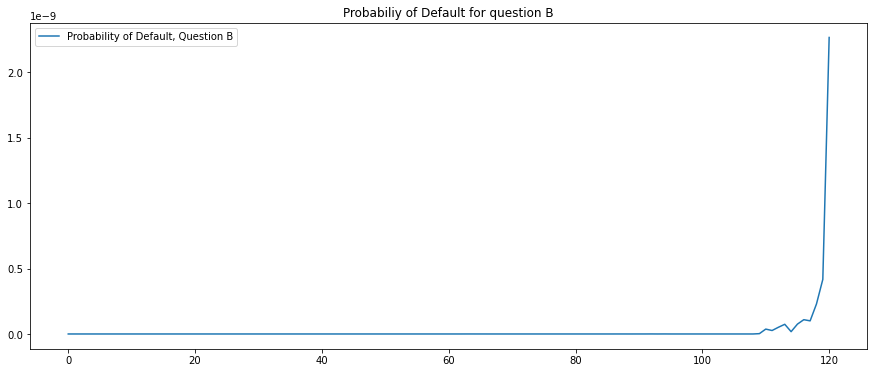

In [58]:
plt.figure(figsize=(15, 6))
plt.title('Probabiliy of Default for question B')
plt.plot(df_B['Probability of Default'], label='Probability of Default, Question B')
# plt.plot(df_C['Probability of Default'], label='Probability of Default, Question C')
# plt.plot(df_D['Probability of Default'], label='Probability of Default, Question D')
# plt.plot(df_E['Probability of Default'], label='Probability of Default, Question E')
# plt.plot(df_F['Probability of Default'], label='Probability of Default, Question F')
plt.legend();

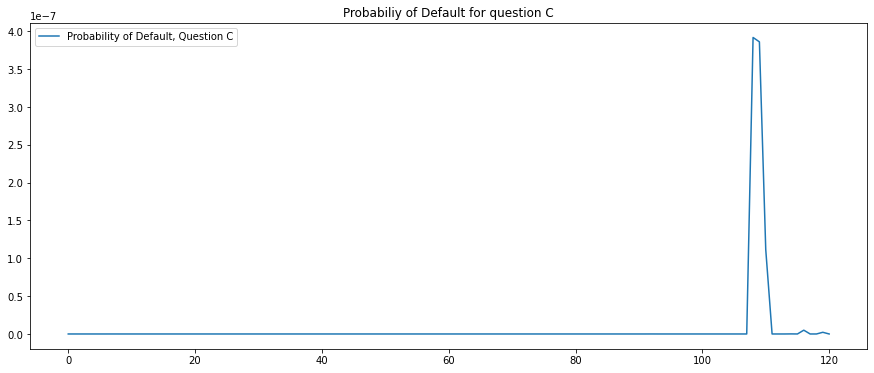

In [59]:
plt.figure(figsize=(15, 6))
plt.title('Probabiliy of Default for question C')
plt.plot(df_C['Probability of Default'], label='Probability of Default, Question C')
plt.legend();

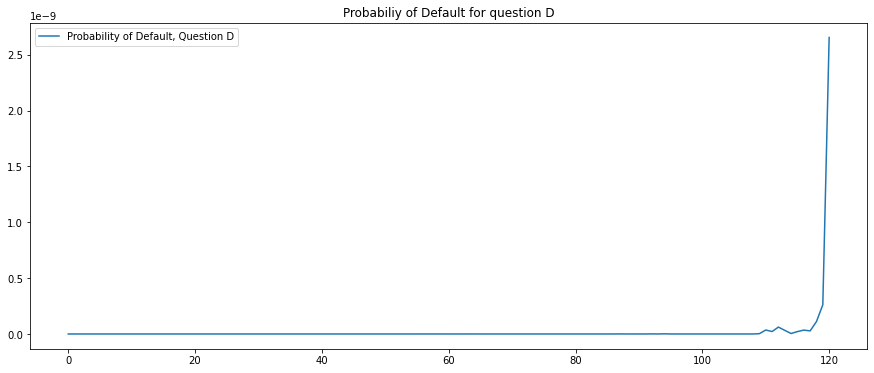

In [62]:
plt.figure(figsize=(15, 6))
plt.title('Probabiliy of Default for question D')
plt.plot(df_D['Probability of Default'], label='Probability of Default, Question D')
plt.legend();

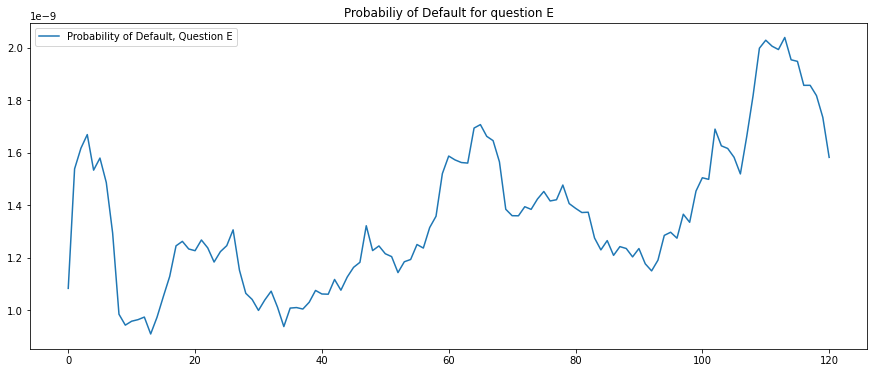

In [61]:
plt.figure(figsize=(15, 6))
plt.title('Probabiliy of Default for question E')
plt.plot(df_E['Probability of Default'], label='Probability of Default, Question E')
plt.legend();

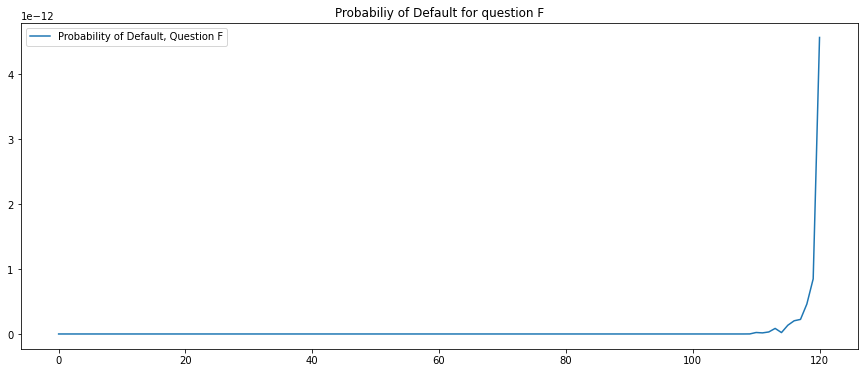

In [60]:
plt.figure(figsize=(15, 6))
plt.title('Probabiliy of Default for question F')
plt.plot(df_F['Probability of Default'], label='Probability of Default, Question F')
plt.legend();